**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [27]:
import numpy as np
from types import SimpleNamespace
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [35]:
# Defining the parameters given
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0
par.kappa = 0.1


def firm_behavior(p, A, gamma, w):
   ell = (p * A * gamma / w) ** (1 / (1 - gamma))
   y = A * (ell ** gamma)
   pi = p * y - w * ell
   return ell, y, pi


def household_behavior(w, T, pi1, pi2, p1, p2, alpha, tau, nu, epsilon):
   ell = ((alpha * w / p1 + (1 - alpha) * w / p2) / nu) ** (1 / (1 + epsilon))
   wealth = w * ell + T + pi1 + pi2
   c1 = alpha * wealth / p1
   c2 = (1 - alpha) * wealth / (p2 + tau)
   return c1, c2, ell
# Numeraire
w = 1


def check_market_clearing(p1_values, p2_values, par, w):
   results = []
   for p1 in p1_values:
       for p2 in p2_values:
           ell1, y1, pi1 = firm_behavior(p1, par.A, par.gamma, w)
           ell2, y2, pi2 = firm_behavior(p2, par.A, par.gamma, w)
          
           c1, c2, ell = household_behavior(w, par.T, pi1, pi2, p1, p2, par.alpha, par.tau, par.nu, par.epsilon)
          
           labor_market_clearing = np.isclose(ell, ell1 + ell2, atol=1e-2)
           good1_market_clearing = np.isclose(c1, y1, atol=1e-2)
           good2_market_clearing = np.isclose(c2, y2, atol=1e-2)
          
           labor_error = ell - (ell1 + ell2)
           good1_error = c1 - y1
           good2_error = c2 - y2
          
           results.append((p1, p2, ell, ell1 + ell2, labor_error, c1, y1, good1_error, c2, y2, good2_error, labor_market_clearing, good1_market_clearing, good2_market_clearing))
   return results

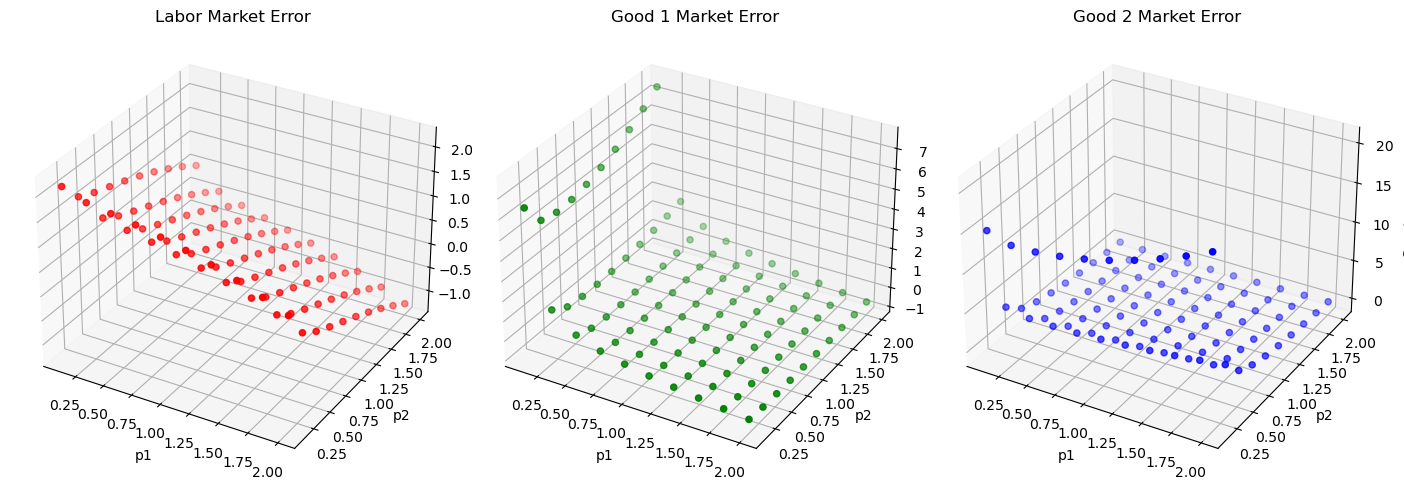

In [36]:
# Price ranges
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)


results = check_market_clearing(p1_values, p2_values, par, w)
df_results = pd.DataFrame(results, columns=['p1', 'p2', 'Labor Supplied', 'Labor Demanded', 'Labor Error', 'Consumption Good 1', 'Production Good 1', 'Good 1 Error', 'Consumption Good 2', 'Production Good 2', 'Good 2 Error', 'Labor Market Clearing', 'Good 1 Market Clearing', 'Good 2 Market Clearing'])


# Extract relevant data
p1 = df_results['p1'].values
p2 = df_results['p2'].values
labor_error = df_results['Labor Error'].values
good1_error = df_results['Good 1 Error'].values
good2_error = df_results['Good 2 Error'].values


# Create 3D plot for labor market error
fig = plt.figure(figsize=(14, 8))


ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(p1, p2, labor_error, c='r', marker='o')
ax1.set_title('Labor Market Error')
ax1.set_xlabel('p1')
ax1.set_ylabel('p2')
ax1.set_zlabel('Labor Error')


# Create 3D plot for good 1 market error
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(p1, p2, good1_error, c='g', marker='o')
ax2.set_title('Good 1 Market Error')
ax2.set_xlabel('p1')
ax2.set_ylabel('p2')
ax2.set_zlabel('Good 1 Error')


# Create 3D plot for good 2 market error
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(p1, p2, good2_error, c='b', marker='o')
ax3.set_title('Good 2 Market Error')
ax3.set_xlabel('p1')
ax3.set_ylabel('p2')
ax3.set_zlabel('Good 2 Error')


plt.tight_layout()
plt.show()

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [37]:
def market_clearing_conditions(prices, par, w):
   p1, p2 = prices
   ell1, y1, pi1 = firm_behavior(p1, par.A, par.gamma, w)
   ell2, y2, pi2 = firm_behavior(p2, par.A, par.gamma, w)
  
   c1, c2, ell = household_behavior(w, par.T, pi1, pi2, p1, p2, par.alpha, par.tau, par.nu, par.epsilon)
  
   labor_market_error = ell - (ell1 + ell2)
   good1_market_error = c1 - y1
  
   return [labor_market_error, good1_market_error]


def excess_demand(prices, par, w):
   p1, p2 = prices
   ell1, y1, pi1 = firm_behavior(p1, par.A, par.gamma, w)
   ell2, y2, pi2 = firm_behavior(p2, par.A, par.gamma, w)
  
   c1, c2, ell = household_behavior(w, par.T, pi1, pi2, p1, p2, par.alpha, par.tau, par.nu, par.epsilon)
  
   excess_demand_good1 = c1 - y1
   excess_demand_good2 = c2 - y2
  
   return excess_demand_good1, excess_demand_good2


# Initial guess for prices
initial_guess = [1.0, 1.0]


# Solve for equilibrium prices
equilibrium_prices = fsolve(market_clearing_conditions, initial_guess, args=(par, w))
p1_equilibrium, p2_equilibrium = equilibrium_prices


# Calculate excess demand at equilibrium prices
excess_demand_good1, excess_demand_good2 = excess_demand(equilibrium_prices, par, w)


print(f"Equilibrium prices: p1 = {p1_equilibrium:.5f}, p2 = {p2_equilibrium:.5f}")
print(f"Excess demand for good 1: {excess_demand_good1:.5f}")
print(f"Excess demand for good 2: {excess_demand_good2:.5f}")

Equilibrium prices: p1 = 1.03936, p2 = 1.58765
Excess demand for good 1: 0.00000
Excess demand for good 2: 0.00000


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

Optimal tau: 0.0000
Optimal T: 103163.7243


## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [21]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


For this question we go through the following procedure:
1. Simulate $K = 10000$ draws of random noise to compute the utility values for each career track.
2. Calculate the expected utility as the mean of the simulated utilities and the average realized utility as the mean of the same simulated utilities.
3. Print the expected and average realized utilities for each career track.

In [22]:
expected_utilities = np.zeros(par.J)
average_realized_utilities = np.zeros(par.J)


for j in range(par.J):
   epsilon = np.random.normal(0, par.sigma, par.K)
   utilities = par.v[j] + epsilon
   expected_utilities[j] = np.mean(utilities)
   average_realized_utilities[j] = np.mean(utilities)


print("Expected Utilities for each career:")
for j in range(par.J):
   print(f"Career {j+1}: {expected_utilities[j]}")


print("\nAverage Realized Utilities for each career:")
for j in range(par.J):
   print(f"Career {j+1}: {average_realized_utilities[j]}")

Expected Utilities for each career:
Career 1: 0.9888485558875371
Career 2: 2.0309629698316747
Career 3: 2.9545147718611027

Average Realized Utilities for each career:
Career 1: 0.9888485558875371
Career 2: 2.0309629698316747
Career 3: 2.9545147718611027


The expected utilities represent the anticipated average utility values for each career track before choosing while the average realized utiliies are the actual average utility values experienced after making the career choice. These are the same for all 3 career choice options.

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

For this question we go through the following procedure:
1. Simulate for each graduate:
- For each graduate with a different number of friends, simulate subjective and realized utilities.
- Compute prior expectations using the average of friends' noise.
- Simulate choices based on the highest subjective utility.
3. Calculate the share of graduates choosing each career.
4. Compute the average subjective utility (expected) and average ex-post (realized) utility for each type of graduate.
5. Plot the share of graduates choosing each career and the average utilities.


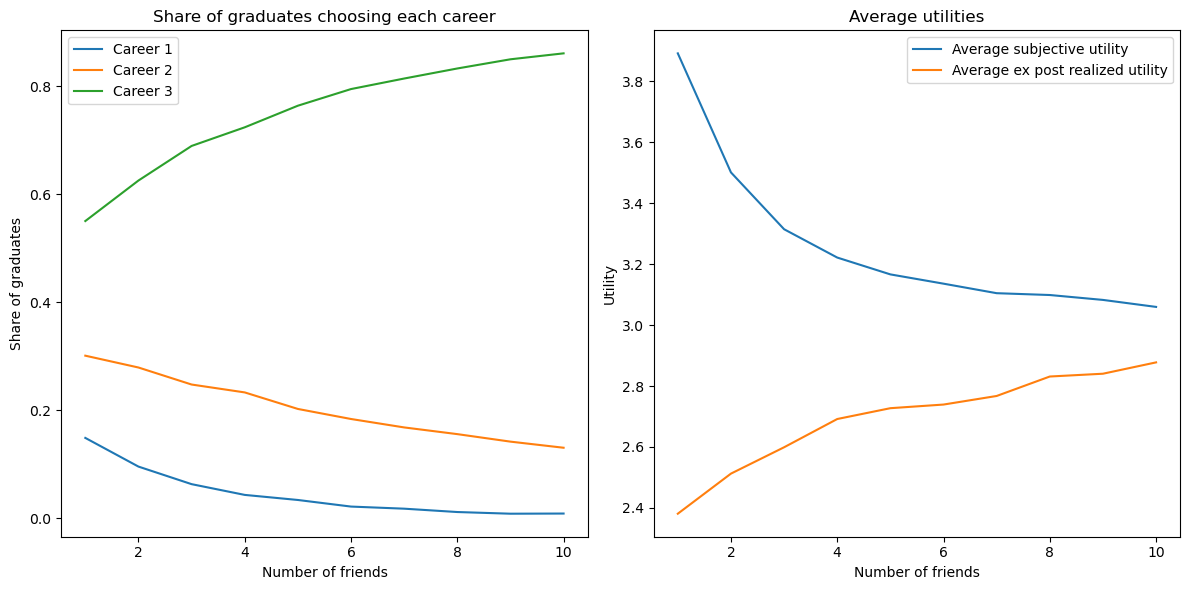

In [23]:
share_of_graduates = np.zeros((par.N, par.J))
average_subjective_utilities = np.zeros(par.N)
average_ex_post_utilities = np.zeros(par.N)


np.random.seed(0)


for i in range(par.N):
   F = par.F[i]  # Number of friends
   subjective_utilities = np.zeros((par.K, par.J))
   realized_utilities = np.zeros((par.K, par.J))
  
   for k in range(par.K):
       noise = np.random.normal(0, par.sigma, (F, par.J))
       prior_expectation = par.v + noise.mean(axis=0)
       subjective_utilities[k] = prior_expectation
       realized_noise = np.random.normal(0, par.sigma, par.J)
       realized_utilities[k] = par.v + realized_noise


   choices = np.argmax(subjective_utilities, axis=1)
   chosen_subjective_utilities = np.take_along_axis(subjective_utilities, choices[:, np.newaxis], axis=1).flatten()
   chosen_realized_utilities = np.take_along_axis(realized_utilities, choices[:, np.newaxis], axis=1).flatten()
  
   for j in range(par.J):
       share_of_graduates[i, j] = np.mean(choices == j)
  
   average_subjective_utilities[i] = np.mean(chosen_subjective_utilities)
   average_ex_post_utilities[i] = np.mean(chosen_realized_utilities)


# Visualization for Question 2
x = np.arange(1, par.N + 1)
plt.figure(figsize=(12, 6))


# Share of graduates choosing each career
plt.subplot(1, 2, 1)
for j in range(par.J):
   plt.plot(x, share_of_graduates[:, j], label=f'Career {j+1}')
plt.xlabel('Number of friends')
plt.ylabel('Share of graduates')
plt.title('Share of graduates choosing each career')
plt.legend()


# Average utilities
plt.subplot(1, 2, 2)
plt.plot(x, average_subjective_utilities, label='Average subjective utility')
plt.plot(x, average_ex_post_utilities, label='Average ex post realized utility')
plt.xlabel('Number of friends')
plt.ylabel('Utility')
plt.title('Average utilities')
plt.legend()


plt.tight_layout()
plt.show()


The share of graduates choosing each career shows the distribution of career choices based on the number of friends. The average subjective utilities show the expected utility values based on friends' information. The average ex-post utilities show the actual utility values experienced after making a career choice.


The graphs show that when the number of friends increase more are choosing career 3 which also makes the average subjective and ex-post realized utilities closer to each other.


After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

For this question we go through the following procedure:
1. Simulate for each graduate:
- Repeat the initial simulation of subjective and realized utilities.
- Calculate new subjective utilities considering the switching cost.
- Simulate new choices based on the highest new subjective utility.
2. Calculate the share of graduates choosing each career after considering the switching cost.
3. Compute the average subjective (expected) utility and average ex-post (realized) utility for each type of graduate after switching.
4. Plot the share of graduates choosing each career after switching and the average utilities.

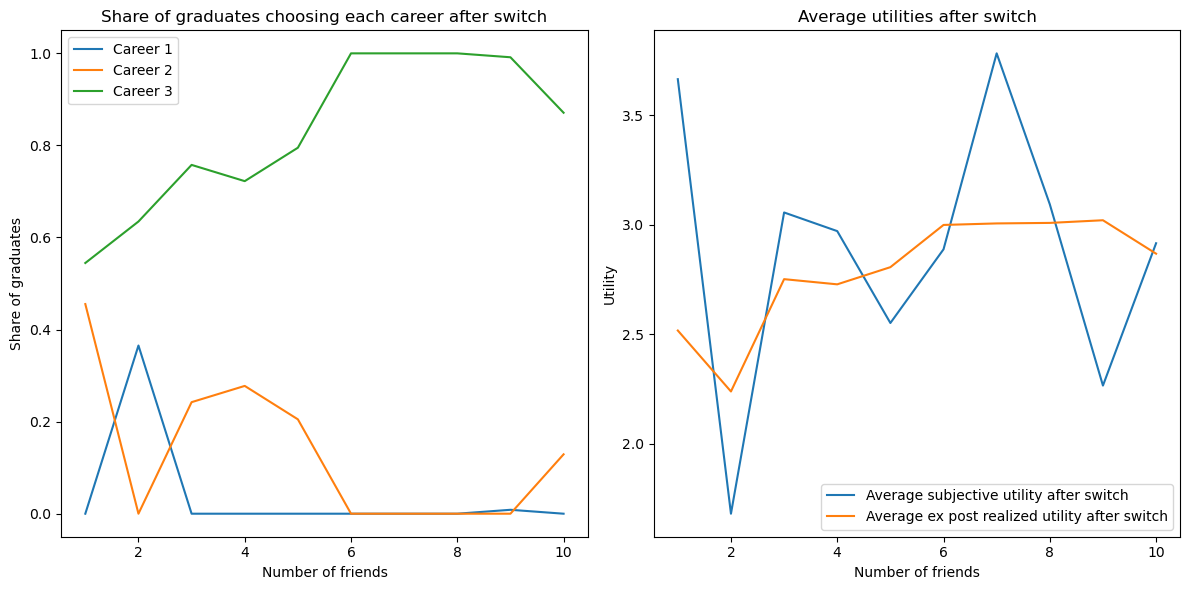

In [24]:
average_subjective_utilities_after_switch = np.zeros(par.N)
average_ex_post_utilities_after_switch = np.zeros(par.N)
share_of_switchers = np.zeros((par.N, par.J))


for i in range(par.N):
   F = par.F[i]  # Number of friends
   subjective_utilities = np.zeros((par.K, par.J))
   realized_utilities = np.zeros((par.K, par.J))
   new_subjective_utilities = np.zeros((par.K, par.J))


   for k in range(par.K):
       noise = np.random.normal(0, par.sigma, (F, par.J))
       prior_expectation = par.v + noise.mean(axis=0)
       subjective_utilities[k] = prior_expectation
       realized_noise = np.random.normal(0, par.sigma, par.J)
       realized_utilities[k] = par.v + realized_noise


   choices = np.argmax(subjective_utilities, axis=1)
   chosen_realized_utilities = np.take_along_axis(realized_utilities, choices[:, np.newaxis], axis=1).flatten()


   for j in range(par.J):
       new_noise = np.random.normal(0, par.sigma, (F, par.J))
       new_prior_expectation = par.v + new_noise.mean(axis=0)
       new_subjective_utilities[:, j] = new_prior_expectation[j] - par.c * (choices != j)
  
   new_choices = np.argmax(new_subjective_utilities, axis=1)
   new_chosen_realized_utilities = np.take_along_axis(realized_utilities, new_choices[:, np.newaxis], axis=1).flatten()
  
   for j in range(par.J):
       share_of_switchers[i, j] = np.mean(new_choices == j)


   average_subjective_utilities_after_switch[i] = np.mean(np.take_along_axis(new_subjective_utilities, new_choices[:, np.newaxis], axis=1).flatten())
   average_ex_post_utilities_after_switch[i] = np.mean(new_chosen_realized_utilities)


# Visualization for Question 3
plt.figure(figsize=(12, 6))


# Share of graduates choosing each career after switch
plt.subplot(1, 2, 1)
for j in range(par.J):
   plt.plot(x, share_of_switchers[:, j], label=f'Career {j+1}')
plt.xlabel('Number of friends')
plt.ylabel('Share of graduates')
plt.title('Share of graduates choosing each career after switch')
plt.legend()


# Average utilities after switch
plt.subplot(1, 2, 2)
plt.plot(x, average_subjective_utilities_after_switch, label='Average subjective utility after switch')
plt.plot(x, average_ex_post_utilities_after_switch, label='Average ex post realized utility after switch')
plt.xlabel('Number of friends')
plt.ylabel('Utility')
plt.title('Average utilities after switch')
plt.legend()


plt.tight_layout()
plt.show()

The share of graduates choosing each career after switching shows the distribuation of career choices after considering the cost of switching. The average subjective utilities after switching show the expected utility values after the possibility of switching. The average ex-post utilites after swithcing show the actual utility values experiences after potentially changing careers.

The share of graduates choosing each career now fluctuates a bit more at each number of friends. Career 3 is still the most chosen.

The subjective and realized utility also fluctuates a low more.


## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [44]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

We have a set of random points in the unit square and know the value of some function $(f(x_1, x_2))$ at these points. We want to approximate the value $(f(y_1, y_2))$ for some point $(y = (y_1, y_2))$, where $(y_1)$ and $(y_2)$ are in the unit square.

We follow these steps:

**Function Definition**

We define the function $f(x)$ as the product of its two components: $f(x) = x[0] \times x[1]$.

**Finding Points $A$, $B$, $C$, and $D$**

The function `find_points` identifies four key points around a given point $y$:

- **$A$**: The closest point to $y$ where $x[0] > y[0]$ and $x[1] > y[1]$.
- **$B$**: The closest point to $y$ where $x[0] > y[0]$ and $x[1] < y[1]$.
- **$C$**: The closest point to $y$ where $x[0] < y[0]$ and $x[1] < y[1]$.
- **$D$**: The closest point to $y$ where $x[0] < y[0]$ and $x[1] > y[1]$.

**Computing Barycentric Coordinates**

The function `barycentric_coordinates` calculates the barycentric coordinates $r1$, $r2$, and $r3$ of the point $y$ with respect to the vertices of a given triangle $ABC$.

**Interpolation**

The function `interpolate` determines which triangle $y$ is inside by checking the barycentric coordinates.

- If $y$ is inside triangle $ABC$, it uses the barycentric coordinates to interpolate the value of $f(y)$ based on $A$, $B$, and $C$.
- If $y$ is inside triangle $CDA$, it uses the barycentric coordinates to interpolate the value of $f(y)$ based on $C$, $D$, and $A$.

**Plotting**

The function `plot_interpolation` visualizes the points $X$, $y$, $A$, $B$, $C$, and $D$ along with the triangles $ABC$ and $CDA$.

**Execution**

1. We call `find_points` to get $A$, $B$, $C$, and $D$.
2. We plot the results using `plot_interpolation`.






Coordinates of A: [0.26071605 0.43635845]
Coordinates of B: [0.21315735 0.274245  ]
Coordinates of C: [0.10056103 0.27951775]
Coordinates of D: [0.20634391 0.44272557]


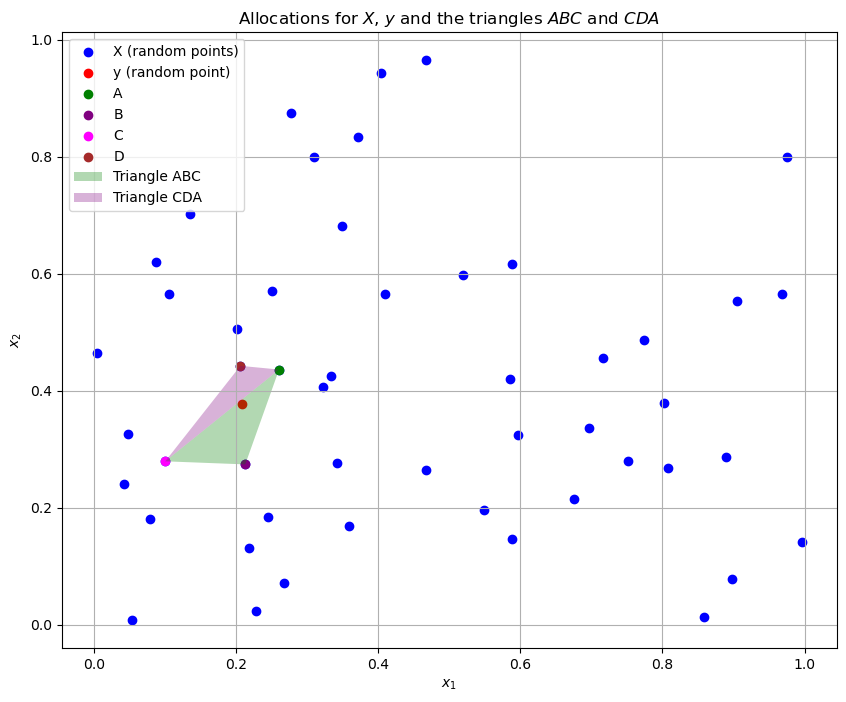

In [46]:
# Function definition
f = lambda x: x[0] * x[1]
F = np.array([f(x) for x in X])

# Define points A, B, C, D based on proximity to y
def find_points(X, y):
    A = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] > y[0] and x[1] > y[1] else float('inf'))
    B = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] > y[0] and x[1] < y[1] else float('inf'))
    C = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] < y[0] and x[1] < y[1] else float('inf'))
    D = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] < y[0] and x[1] > y[1] else float('inf'))
    return A, B, C, D

# Compute barycentric coordinates
def barycentric_coordinates(y, A, B, C):
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / ((B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1]))
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / ((B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1]))
    r3 = 1 - r1 - r2
    return r1, r2, r3

# Determine which triangle y is in and interpolate
def interpolate(y, A, B, C, D):
    rABC1, rABC2, rABC3 = barycentric_coordinates(y, A, B, C)
    if 0 <= rABC1 <= 1 and 0 <= rABC2 <= 1 and 0 <= rABC3 <= 1:
        return rABC1 * f(A) + rABC2 * f(B) + rABC3 * f(C)
    
    rCDA1, rCDA2, rCDA3 = barycentric_coordinates(y, C, D, A)
    if 0 <= rCDA1 <= 1 and 0 <= rCDA2 <= 1 and 0 <= rCDA3 <= 1:
        return rCDA1 * f(C) + rCDA2 * f(D) + rCDA3 * f(A)
    
    return float('nan')

# Plot points and the triangles
def plot_interpolation(X, y, A, B, C, D):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], color='blue', label='X (random points)')
    plt.scatter([y[0]], [y[1]], color='red', label='y (random point)')
    plt.scatter([A[0]], [A[1]], color='green', label='A')
    plt.scatter([B[0]], [B[1]], color='purple', label='B')
    plt.scatter([C[0]], [C[1]], color='magenta', label='C')
    plt.scatter([D[0]], [D[1]], color='brown', label='D')
    
    plt.fill([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'green', alpha=0.3, label='Triangle ABC')
    plt.fill([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'purple', alpha=0.3, label='Triangle CDA')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.title('Allocations for $X$, $y$ and the triangles $ABC$ and $CDA$')
    plt.grid(True)
    plt.show()

# Find points and interpolate
A, B, C, D = find_points(X, y)

print(f"Coordinates of A: {A}")
print(f"Coordinates of B: {B}")
print(f"Coordinates of C: {C}")
print(f"Coordinates of D: {D}")

# Plot the results
plot_interpolation(X, y, A, B, C, D)


**Conclusion**

In this exercise, we successfully applied barycentric interpolation to approximate the value of a function at a given point within the unit square. We generated random points and identified the nearest points \( A \), \( B \), \( C \), and \( D \) that form triangles around our target point \( y \). 

The coordinates for the points are as follows:
- Coordinates of $( A )$: $([0.26, 0.44])$
- Coordinates of $( B )$: $([0.21, 0.27])$
- Coordinates of $( C )$: $([0.10, 0.28])$
- Coordinates of $( D )$: $([0.21, 0.44])$



**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

We continue our exploration of barycentric interpolation. Our goal is to compute the barycentric coordinates of a given point $(y)$ with respect to the triangles $(ABC)$ and $(CDA)$. By doing so, we can determine which of these triangles $(y)$ lies within. This step is crucial for the interpolation process, as it allows us to accurately estimate the function value at $(y)$ using the vertices of the appropriate triangle.

We follow these steps:

1. **Compute Barycentric Coordinates:**
   - We first calculate the barycentric coordinates of the point $(y)$ with respect to the triangle $(ABC)$
   - Next, we calculate the barycentric coordinates of the point $(y)$ with respect to the triangle $(CDA)$

2. **Determine Triangle Containment:**
   - Using the computed barycentric coordinates, we determine which triangle $(y)$ is located inside. 

3. **Implementation:**
   - We define a function to calculate the barycentric coordinates for any point given the vertices of a triangle.
   - We then use this function to compute the barycentric coordinates of $(y)$ with respect to both triangles.
   - Finally, we determine which triangle contains $(y)$ based on the computed coordinates.

By following these steps, we can accurately identify the triangle that contains the point $(y)$, which is essential for performing precise barycentric interpolation.


In [13]:
# Find points and interpolate
A, B, C, D = find_points(X, y)

# Compute barycentric coordinates
rABC1, rABC2, rABC3 = barycentric_coordinates(y, A, B, C)
rCDA1, rCDA2, rCDA3 = barycentric_coordinates(y, C, D, A)

# Determine which triangle y is in
def which_triangle(rABC1, rABC2, rABC3, rCDA1, rCDA2, rCDA3):
    if 0 <= rABC1 <= 1 and 0 <= rABC2 <= 1 and 0 <= rABC3 <= 1:
        return "ABC"
    elif 0 <= rCDA1 <= 1 and 0 <= rCDA2 <= 1 and 0 <= rCDA3 <= 1:
        return "CDA"
    else:
        return "None"

triangle = which_triangle(rABC1, rABC2, rABC3, rCDA1, rCDA2, rCDA3)

# Print the results
print(f"Barycentric coordinates with respect to ABC: r1 = {rABC1:.4f}, r2 = {rABC2:.4f}, r3 = {rABC3:.4f}")
print(f"Barycentric coordinates with respect to CDA: r1 = {rCDA1:.4f}, r2 = {rCDA2:.4f}, r3 = {rCDA3:.4f}")
print(f"Point y is located inside triangle: {triangle}")




Barycentric coordinates with respect to ABC: r1 = 0.6286, r2 = 0.0691, r3 = 0.3023
Barycentric coordinates with respect to CDA: r1 = 0.3683, r2 = -0.1339, r3 = 0.7657
Point y is located inside triangle: ABC


The barycentric coordinates for point y with respect to triangle ABC are all between 0 and 1, indicating that point y lies inside triangle 
ABC.

The barycentric coordinates with respect to triangle CDA include a negative value $(r2=−0.1339)$, indicating that point y does not lie within this triangle.

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [14]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

We start by defining the function to compute the value of $f(x)$. We then use the barycentric coordinates to compute the interpolation for the function $(f)$ at the point $(y)$. Then we compare this with the true value of the function at $(y)$.


In [15]:
# Define points A, B, C, D based on proximity to y
def find_points(X, y):
    A = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] > y[0] and x[1] > y[1] else float('inf'))
    B = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] > y[0] and x[1] < y[1] else float('inf'))
    C = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] < y[0] and x[1] < y[1] else float('inf'))
    D = min(X, key=lambda x: np.linalg.norm(x - y) if x[0] < y[0] and x[1] > y[1] else float('inf'))
    return A, B, C, D

# Compute barycentric coordinates
def barycentric_coordinates(y, A, B, C):
    denominator = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denominator
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denominator
    r3 = 1 - r1 - r2
    return r1, r2, r3

# Determine which triangle y is in and interpolate
def interpolate(y, A, B, C, D):
    rABC1, rABC2, rABC3 = barycentric_coordinates(y, A, B, C)
    if 0 <= rABC1 <= 1 and 0 <= rABC2 <= 1 and 0 <= rABC3 <= 1:
        return rABC1 * f(A) + rABC2 * f(B) + rABC3 * f(C)
    
    rCDA1, rCDA2, rCDA3 = barycentric_coordinates(y, C, D, A)
    if 0 <= rCDA1 <= 1 and 0 <= rCDA2 <= 1 and 0 <= rCDA3 <= 1:
        return rCDA1 * f(C) + rCDA2 * f(D) + rCDA3 * f(A)
    
    return float('nan')

# Find points and interpolate
A, B, C, D = find_points(X, y)
interpolated_value = interpolate(y, A, B, C, D)
true_value = f(y)

# Print the results
print(f"Interpolated value: {interpolated_value:.4f}")
print(f"True value: {true_value:.4f}")


Interpolated value: 0.0841
True value: 0.0790


Overall, the approximation for the function value $f(y)$ is close to the true value of $f(y)$, with only a small difference $(0.084)$ vs. $(0.079)$, indicating a reasonable approximation.

**Question 4:** Repeat question 3 for all points in the set $Y$.

We have repeated for the following points $(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.5,0.5)$ and assumed that it is a mistake that this point $(0.8,0.2)$ is mentioned twice

**We follow these steps:**

Defines the set Y with the given points.

Iterates through each point in Y, finds the necessary points A,B,C,D, calculates the barycentric coordinates, and interpolates the value of $f(y)$ 

Compares the interpolated values with the true values and prints the results.

Point: (0.2, 0.2)
Interpolated value: 0.0403
True value: 0.0400
Difference: -0.0003
-----------


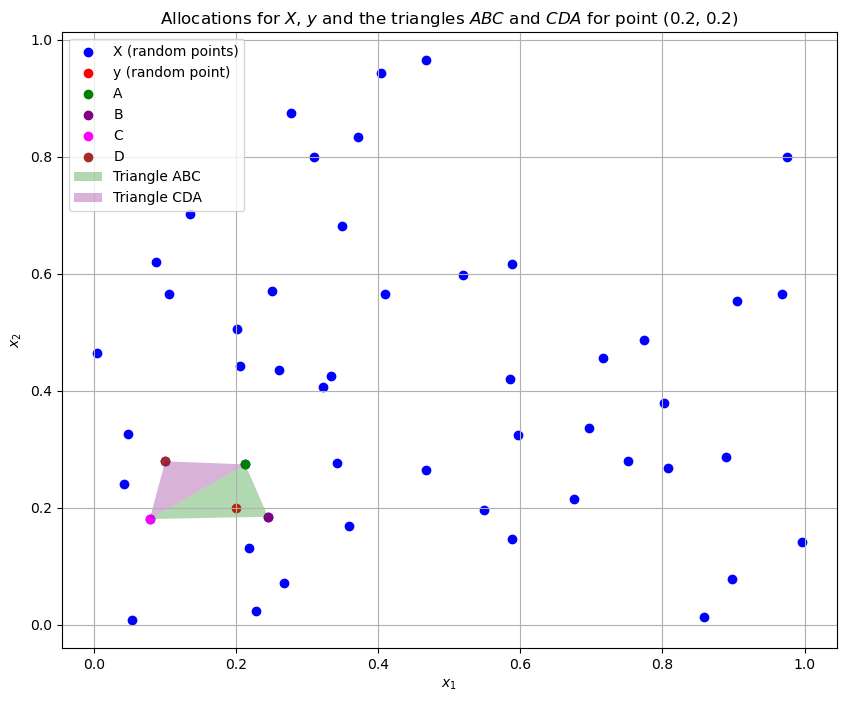

Point: (0.8, 0.2)
Interpolated value: 0.1587
True value: 0.1600
Difference: 0.0013
-----------


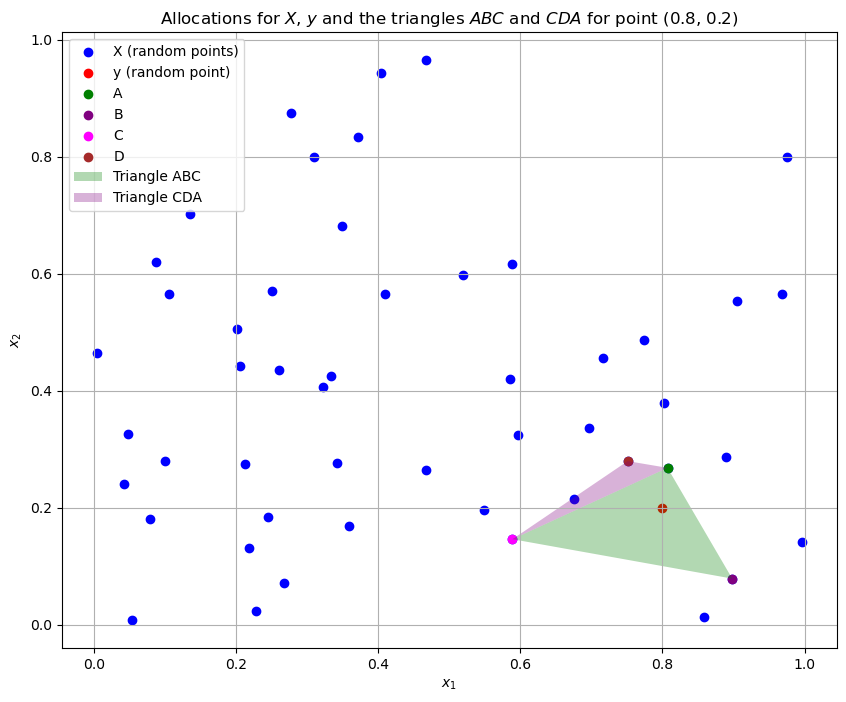

Point: (0.8, 0.8)
Interpolated value: nan
True value: 0.6400
Difference: nan
-----------


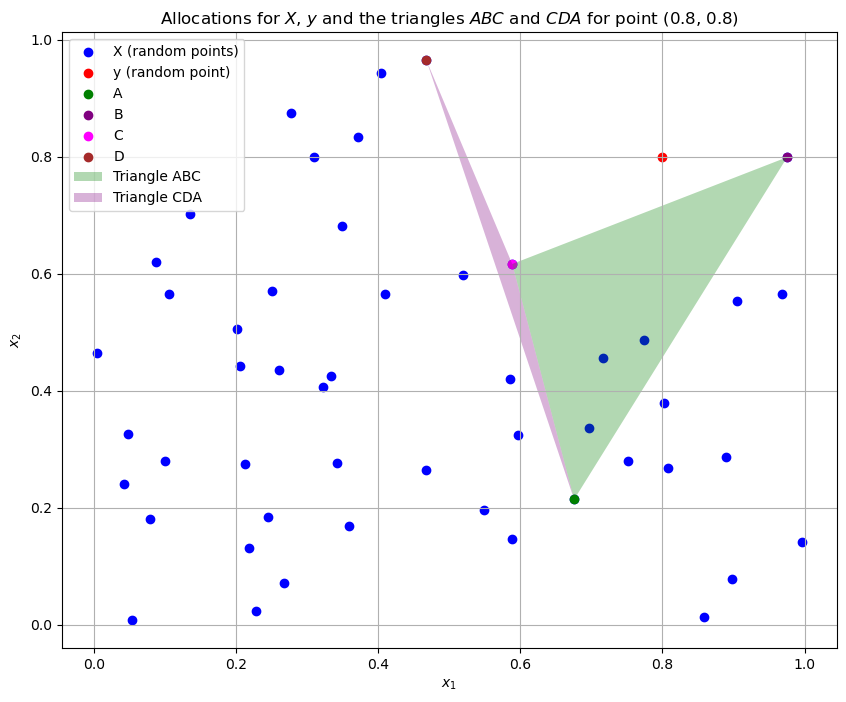

Point: (0.5, 0.5)
Interpolated value: 0.2513
True value: 0.2500
Difference: -0.0013
-----------


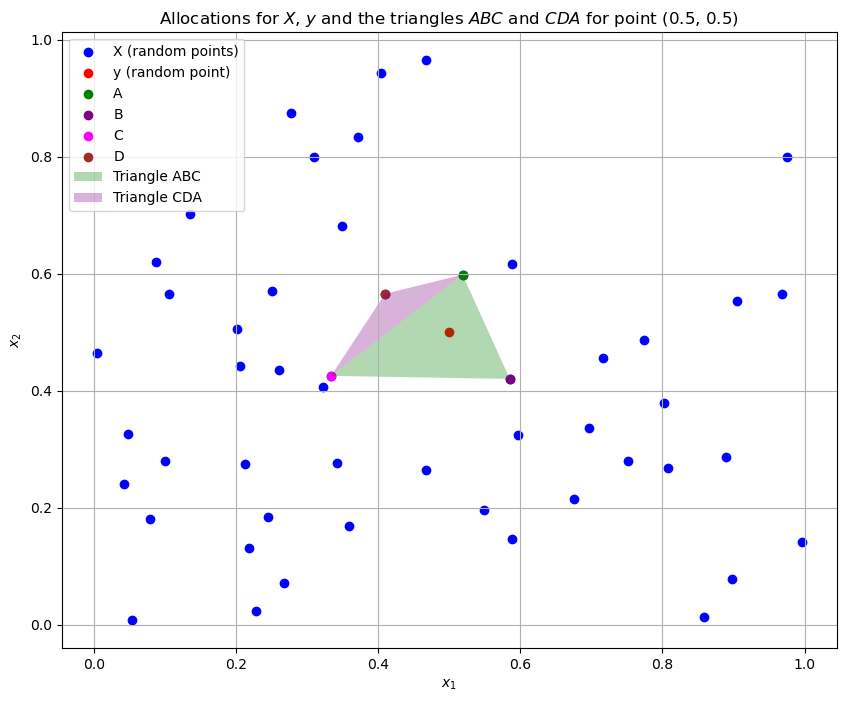

In [19]:
# Points in set Y
Y = [(0.2, 0.2), (0.8, 0.2), (0.8, 0.8), (0.5, 0.5)]

# Interpolate and compare for each point in Y
for point in Y:
    y = np.array(point)
    A, B, C, D = find_points(X, y)
    interpolated_value = interpolate(y, A, B, C, D)
    true_value = f(y)
    print(f"Point: {point}")
    print(f"Interpolated value: {interpolated_value:.4f}")
    print(f"True value: {true_value:.4f}")
    print(f"Difference: {true_value - interpolated_value:.4f}")
    print("-----------")

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], color='blue', label='X (random points)')
    plt.scatter([y[0]], [y[1]], color='red', label='y (random point)')
    plt.scatter([A[0]], [A[1]], color='green', label='A')
    plt.scatter([B[0]], [B[1]], color='purple', label='B')
    plt.scatter([C[0]], [C[1]], color='magenta', label='C')
    plt.scatter([D[0]], [D[1]], color='brown', label='D')
    
    plt.fill([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'green', alpha=0.3, label='Triangle ABC')
    plt.fill([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'purple', alpha=0.3, label='Triangle CDA')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.title(f'Allocations for $X$, $y$ and the triangles $ABC$ and $CDA$ for point {point}')
    plt.grid(True)
    plt.show()


The barycentric interpolation method provided accurate approximations for the function values at the given points in the set Y. The differences between the interpolated values and the true values were minimal, demonstrating the effectiveness and reliability of this interpolation technique.

Overall, the interpolation results indicate that the method is robust and provides accurate approximations, validating its use for interpolating values in the unit square.





